In [1]:
from utils import *
from models import *
from train import *

In [2]:
dataloader_train, dataloader_val, dataloader_test = load_data()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(num_classes=3).to(device)
print([name for name, param in model.named_parameters() if param.requires_grad]) # check that the BERT parameters are well frozen
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=1e-4)
num_epochs = 1
patience=5

['decoder.attention.in_proj_weight', 'decoder.attention.in_proj_bias', 'decoder.attention.out_proj.weight', 'decoder.attention.out_proj.bias', 'decoder.layer_norm.weight', 'decoder.layer_norm.bias', 'decoder.fc.weight', 'decoder.fc.bias']


  0%|          | 0/25 [00:02<?, ?it/s]


Epoch [1/1], Train Loss: 0.9636, Valid Loss: 1.2657, Valid Accuracy: 0.2500, Valid F1 score: 0.2074


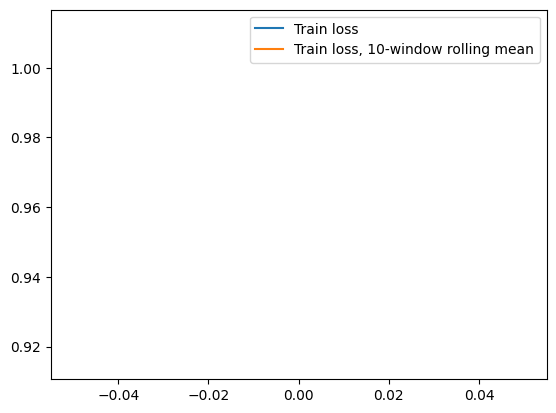

Validation loss improved, saving model...



In [4]:
train(device, dataloader_train, dataloader_val, model, optimizer, num_epochs, patience, experiment_name='check')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(num_classes=3).to(device)
print([name for name, param in model.named_parameters() if param.requires_grad]) # check that the BERT parameters are well frozen
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=1e-4)
num_epochs = 1
patience=5

['decoder.attention.in_proj_weight', 'decoder.attention.in_proj_bias', 'decoder.attention.out_proj.weight', 'decoder.attention.out_proj.bias', 'decoder.layer_norm.weight', 'decoder.layer_norm.bias', 'decoder.fc.weight', 'decoder.fc.bias']


  0%|          | 0/25 [00:02<?, ?it/s]


Epoch [1/1], Train Loss: 1.4295, Valid Loss: 1.4988, Valid Sparsity penalty: 0.4295, Valid Accuracy: 0.3750, Valid F1 score: 0.3214


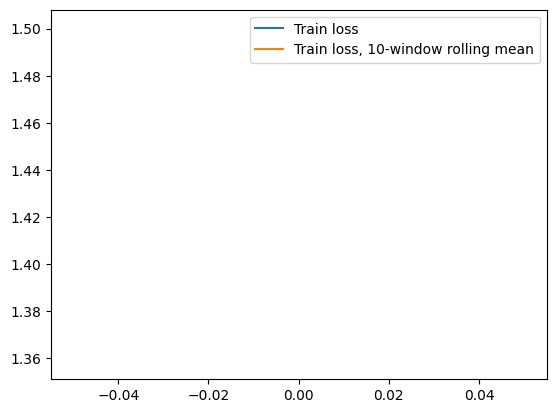

Validation loss improved, saving model...



In [6]:
train(device, dataloader_train, dataloader_val, model, optimizer, num_epochs, patience, add_sparsity_penalty=True, experiment_name='check_sparsity_penalty')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HardThresholdingBERTClassifier(num_classes=3, threshold=0.02).to(device)
print([name for name, param in model.named_parameters() if param.requires_grad]) # check that the BERT parameters are well frozen
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=1e-4)
num_epochs = 1
patience=5

['decoder.attention.query_proj.weight', 'decoder.attention.query_proj.bias', 'decoder.attention.key_proj.weight', 'decoder.attention.key_proj.bias', 'decoder.attention.value_proj.weight', 'decoder.attention.value_proj.bias', 'decoder.layer_norm.weight', 'decoder.layer_norm.bias', 'decoder.fc.weight', 'decoder.fc.bias']


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(31360., grad_fn=<SumBackward0>)


  0%|          | 0/25 [00:01<?, ?it/s]

tensor(31360.0020)
Epoch [1/1], Train Loss: 1.2397, Valid Loss: 1.1587, Valid Accuracy: 0.3125, Valid F1 score: 0.1974


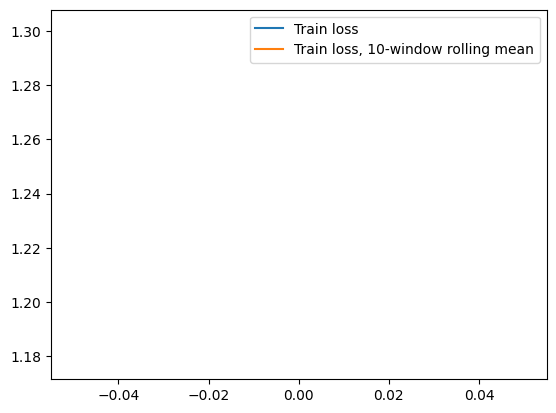

Validation loss improved, saving model...



In [8]:
train(device, dataloader_train, dataloader_val, model, optimizer, num_epochs, patience, experiment_name='check_hardthresholding')

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemperatureBERTClassifier(num_classes=3, temperature=0.5).to(device)
print([name for name, param in model.named_parameters() if param.requires_grad]) # check that the BERT parameters are well frozen
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=1e-4)
num_epochs = 1
patience=5

['decoder.attention.query_proj.weight', 'decoder.attention.query_proj.bias', 'decoder.attention.key_proj.weight', 'decoder.attention.key_proj.bias', 'decoder.attention.value_proj.weight', 'decoder.attention.value_proj.bias', 'decoder.layer_norm.weight', 'decoder.layer_norm.bias', 'decoder.fc.weight', 'decoder.fc.bias']


  0%|          | 0/25 [00:01<?, ?it/s]


Epoch [1/1], Train Loss: 1.0226, Valid Loss: 1.0661, Valid Accuracy: 0.3125, Valid F1 score: 0.3135


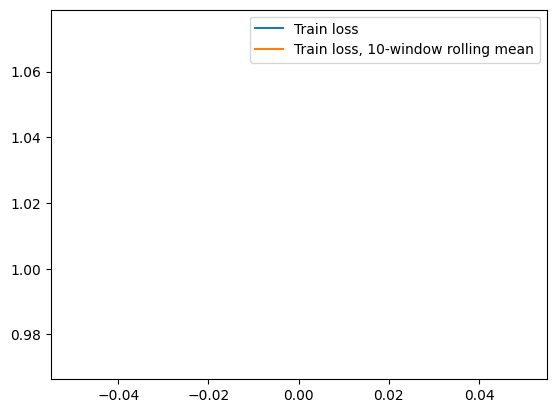

Validation loss improved, saving model...



In [10]:
train(device, dataloader_train, dataloader_val, model, optimizer, num_epochs, patience, experiment_name='check_temperature')

In [11]:
class LoRA(nn.Module):
    def __init__(self, in_features, out_features, r=8, lora_alpha=32, lora_dropout=0.1):
        super(LoRA, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.r = r
        self.lora_alpha = lora_alpha
        self.lora_dropout = lora_dropout
        
        self.lora_A = nn.Parameter(torch.randn(in_features, r))
        self.lora_B = nn.Parameter(torch.randn(out_features, r))
        self.dropout = nn.Dropout(lora_dropout)

    def forward(self, x):
        A = self.lora_A
        B = self.lora_B
        output = x + self.dropout(torch.matmul(x, A) @ B.T / self.lora_alpha)
        return output

In [12]:
class LoRABERTClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.1):
        super(LoRABERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters(): # freeze BERT encoder
            param.requires_grad = False
            
        modules_to_replace = []
        for name, module in self.bert.named_modules():
            if isinstance(module, nn.Linear) and ('query' in name or 'key' in name or 'value' in name):
                modules_to_replace.append((name, module))
        
        for name, module in modules_to_replace:
            in_features = module.in_features
            out_features = module.out_features
            lora_module = LoRA(in_features, out_features, r=8, lora_alpha=32, lora_dropout=0.1)
            setattr(self.bert, name, nn.Sequential(module, lora_module))
        
        self.decoder = AttentionalDecoder(self.bert.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask, **kwargs):
        encoder_output = self.bert(
            input_ids, 
            attention_mask=attention_mask
        ).last_hidden_state
        
        encoder_output = self.dropout(encoder_output)
        output = self.decoder(encoder_output, attention_mask)
        return output

    def save_decoder_weights(self, path):
        '''
        Utility function to save the weights of the lora layers and the decoder
        '''
        lora_decoder_weights = {
            'lora': {name: param for name, param in self.named_parameters() if 'lora' in name},
            'decoder': {name: param for name, param in self.named_parameters() if 'decoder' in name}
        }
        torch.save(lora_decoder_weights, path)
    
    def load_decoder_weights(self, path):
        '''
        Utility function to load the weights of the lora layers and the decoder
        '''
        lora_decoder_weights = torch.load(path)
        lora_state_dict = {k: v for k, v in lora_decoder_weights['lora'].items() if 'lora' in k}
        decoder_state_dict = {k: v for k, v in lora_decoder_weights['decoder'].items() if 'decoder' in k}

        # Load LoRA weights
        lora_params = {name: param for name, param in self.named_parameters() if 'lora' in name}
        lora_params.update(lora_state_dict)
        for name, param in lora_params.items():
            self.state_dict()[name].copy_(param)

        # Load decoder weights
        decoder_params = {name: param for name, param in self.named_parameters() if 'decoder' in name}
        decoder_params.update(decoder_state_dict)
        for name, param in decoder_params.items():
            self.state_dict()[name].copy_(param)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LoRABERTClassifier(num_classes=3).to(device)
# print([name for name, param in model.named_parameters()]) # check that the BERT parameters are well frozen
print([name for name, param in model.named_parameters() if param.requires_grad]) # check that the BERT parameters are well frozen

['bert.encoder.layer.0.attention.self.query.1.lora_A', 'bert.encoder.layer.0.attention.self.query.1.lora_B', 'bert.encoder.layer.0.attention.self.key.1.lora_A', 'bert.encoder.layer.0.attention.self.key.1.lora_B', 'bert.encoder.layer.0.attention.self.value.1.lora_A', 'bert.encoder.layer.0.attention.self.value.1.lora_B', 'bert.encoder.layer.1.attention.self.query.1.lora_A', 'bert.encoder.layer.1.attention.self.query.1.lora_B', 'bert.encoder.layer.1.attention.self.key.1.lora_A', 'bert.encoder.layer.1.attention.self.key.1.lora_B', 'bert.encoder.layer.1.attention.self.value.1.lora_A', 'bert.encoder.layer.1.attention.self.value.1.lora_B', 'bert.encoder.layer.2.attention.self.query.1.lora_A', 'bert.encoder.layer.2.attention.self.query.1.lora_B', 'bert.encoder.layer.2.attention.self.key.1.lora_A', 'bert.encoder.layer.2.attention.self.key.1.lora_B', 'bert.encoder.layer.2.attention.self.value.1.lora_A', 'bert.encoder.layer.2.attention.self.value.1.lora_B', 'bert.encoder.layer.3.attention.self.qu

In [14]:
# Create optimizer with different learning rates
decoder_params = model.decoder.parameters()
lora_params = model.bert.parameters()
optimizer = torch.optim.AdamW([
    {'params': decoder_params, 'lr': 1e-4},  # Higher learning rate for decoder
    {'params': lora_params, 'lr': 1e-5}      # Lower learning rate for LoRA
])
num_epochs = 1
patience=5

  0%|          | 0/25 [00:02<?, ?it/s]

Epoch [1/1], Train Loss: 1.4351, Valid Loss: 1.0937, Valid Accuracy: 0.2500, Valid F1 score: 0.3000


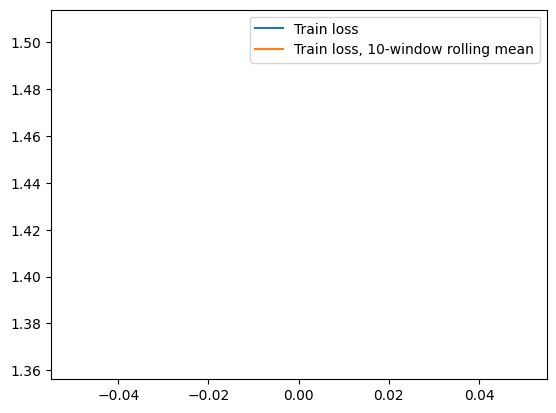

Validation loss improved, saving model...



In [15]:
train(device, dataloader_train, dataloader_val, model, optimizer, num_epochs, patience, experiment_name='check_lora')

In [10]:
model = BERTClassifier(num_classes=3).to(device)
model.load_decoder_weights('best_model.pt')
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [25]:
pred = []
true = labels_test.numpy()
all_cls_attn_weights = []
for input_ids, attention_masks, labels in tqdm(dataloader_test):
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    labels = labels.to(device)   
    with torch.no_grad():
        outputs, cls_attn_weights = model(input_ids=input_ids, attention_mask=attention_masks)
        pred.append(outputs.argmax(dim=1).numpy())
        all_cls_attn_weights.append(cls_attn_weights.numpy())
# test_ce = test_ce / len(dataset_test)
# test_accuracy = test_accuracy/ len(dataset_test)
# test_f1 = f1_score(actual.cpu().detach().numpy(), pred.cpu().detach().numpy(), average='weighted')

100%|██████████| 31/31 [00:39<00:00,  1.28s/it]


In [26]:
test

,sentence,label
0,The U. S. international trade deficit narrowed...,0
1,"Based on historical experience, it seems impro...",0
2,This was also an era when the principal mortga...,2
3,The available data for October suggested that ...,2
4,"However, we have also found that excluding vol...",2
...,...,...
491,"Over the medium term, participants expected st...",0
492,"If so, GDP growth this calendar year could be ...",1
493,Several participants discussed the possible co...,1
494,"Looking ahead, FOMC participants project the u...",2


In [27]:
# Concatenate across batches
pred = np.concatenate(pred, axis=0)
cls_attn_weights = np.concatenate(all_cls_attn_weights, axis=0)

In [28]:
(pred == true).mean()

0.5685483870967742

In [29]:
# il faut masquer et enlever la connexion résiduelle
cls_attn_weights[0].argmax(axis=1)

array([28, 28, 11, 11, 27, 27, 11, 11])

In [32]:
tokenizer.convert_ids_to_tokens(input_ids_test[0])

['[CLS]',
 'the',
 'u',
 '.',
 's',
 '.',
 'international',
 'trade',
 'deficit',
 'narrowed',
 'in',
 'may',
 ',',
 'as',
 'a',
 'large',
 'increase',
 'in',
 'exports',
 'of',
 'goods',
 'and',
 'services',
 'more',
 'than',
 'offset',
 'a',
 'moderate',
 'increase',
 'in',
 'imports',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PA

In [34]:
pred

array([1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2,
       0, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0,
       2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 0, 0,
       1, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0, 1, 2, 1,
       2, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 1, 0, 2, 1, 2, 0, 0, 2, 2, 2,
       2, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2,
       1, 0, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2,
       2, 2, 0, 1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 1, 0, 0,
       0, 2, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2,

In [36]:
true

array([0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 1, 0, 1, 0, 2, 1, 1, 0, 1, 0,
       2, 2, 0, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 1, 0, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 1, 0, 2, 2, 2, 0, 2, 1, 2, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 1, 2, 2, 0, 0, 2, 2,
       0, 1, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 2, 0, 1, 1, 2, 0, 0,
       2, 1, 2, 1, 1, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 0, 0, 2, 0, 2, 1, 2, 1, 2, 2, 1,
       1, 1, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 0, 1, 2, 2,
       2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0,
       1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2,
       1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 0, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 0, 1,
       0, 2, 1, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2,

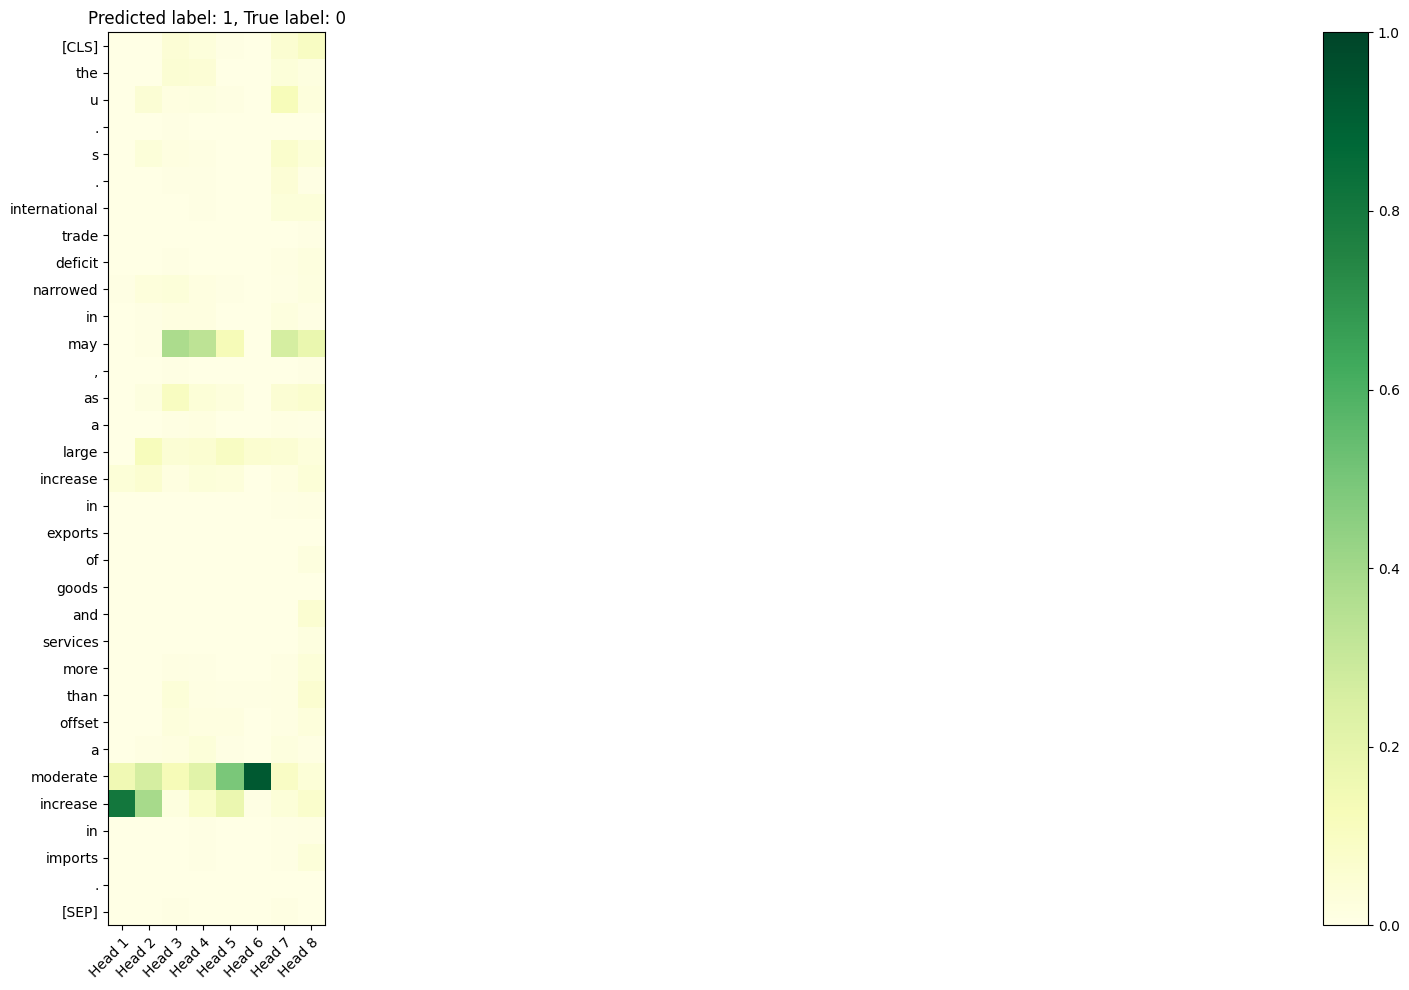

In [33]:
sentence = [tok for tok in tokenizer.convert_ids_to_tokens(input_ids_test[0]) if tok != '[PAD]']
sentence_length = len(sentence) 
heads = [f'Head {i}' for i in range(1, 9)]
cls_weights = cls_attn_weights[0, :, :sentence_length].T

fig, ax = plt.subplots(figsize=(200, 10))
im = ax.imshow(cls_weights, cmap="YlGn", vmin=0, vmax=1)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(heads)), labels=heads,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(sentence)), labels=sentence)

# fig.suptitle('Example of well classified sentence')
ax.set_title(f"Predicted label: {pred[0]}, True label: {labels_test[0]}")
fig.tight_layout()
plt.show()

In [ ]:
# Faire une prédiction sur le test et récupérer les poids d'attention

In [ ]:
# Il faut faire un plt.imshow pour visualiser les poids d'attention facilement